In [1]:
import sys
import os
from config import DATASET_PATH, DATASET_SPLIT_PATH,PREPROCESSING_PATH,TRAIN_TEST_SPLIT_PATH

In [2]:
sys.path.append(PREPROCESSING_PATH)
sys.path.append(TRAIN_TEST_SPLIT_PATH)

In [3]:
import preprocessing
import train_test_val_split
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np 
import pathlib
import tensorflow as tf
import random 
from scipy.io import wavfile

# Exploratory data analysis

## Commands in the dataset

The dataset consists of audio clips that are stored in 35 subdirectories, each corresponding to a specific speech command:
<br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`

In [4]:
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
# Filter out only subdirectories and leave out the noise
commands = [item for item in commands if os.path.isdir(data_dir / item) and item != '_background_noise_']

print('Commands:', commands)
print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


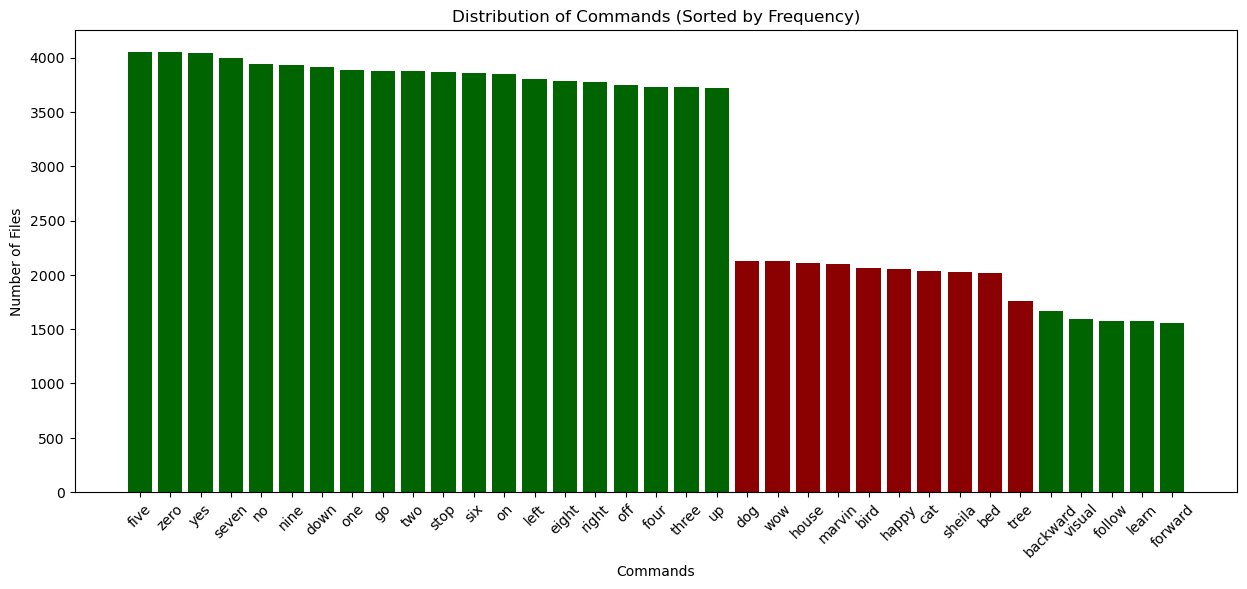

In [5]:
def count_files_by_command(data_path):
    command_counts = {}

    for subdir in os.listdir(data_path):
        # Skip the _background_noise_ directory
        if subdir == "_background_noise_":
            continue
        subdir_path = os.path.join(data_path, subdir)

        # Check if the path is a directory
        if os.path.isdir(subdir_path):
            count = 0
            for filename in os.listdir(subdir_path):
                if filename.endswith('.wav'):
                    count += 1
            command_counts[subdir] = count

    return command_counts

def plot_command_distribution(command_distribution, special_commands):
    # Sort the commands by count in descending order
    sorted_commands = sorted(command_distribution.items(), key=lambda x: x[1], reverse=True)
    commands = [cmd[0] for cmd in sorted_commands]
    counts = [cmd[1] for cmd in sorted_commands]

    colors = ['darkred' if cmd in special_commands else 'darkgreen' for cmd in commands]

    plt.figure(figsize=(15, 6))
    plt.bar(commands, counts, color=colors)
    plt.xlabel('Commands')
    plt.ylabel('Number of Files')
    plt.title('Distribution of Commands (Sorted by Frequency)')
    plt.xticks(rotation=45)
    plt.show()


# Usage example# Replace with the path to your main directory
command_distribution = count_files_by_command(DATASET_PATH)
no_trigger_words = ["bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]

plot_command_distribution(command_distribution, no_trigger_words)

The plot shows the distribution of commands in the dataset. The green commands represent the keywords that should be detected:
`backward`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `learn`, `left`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `six`, `stop`, `three`, `two`, `up`, `visual`, `yes`, `zero`

The red commands are those that should not be recognized as keywords:
`bed`,`bird`,`cat`, `dog`,`happy`,`house`,`marvin`,`sheila`,`tree`,`wow`

## Plot data samples

Choosing randomly 9 different samples from the dataset and plot their waveform

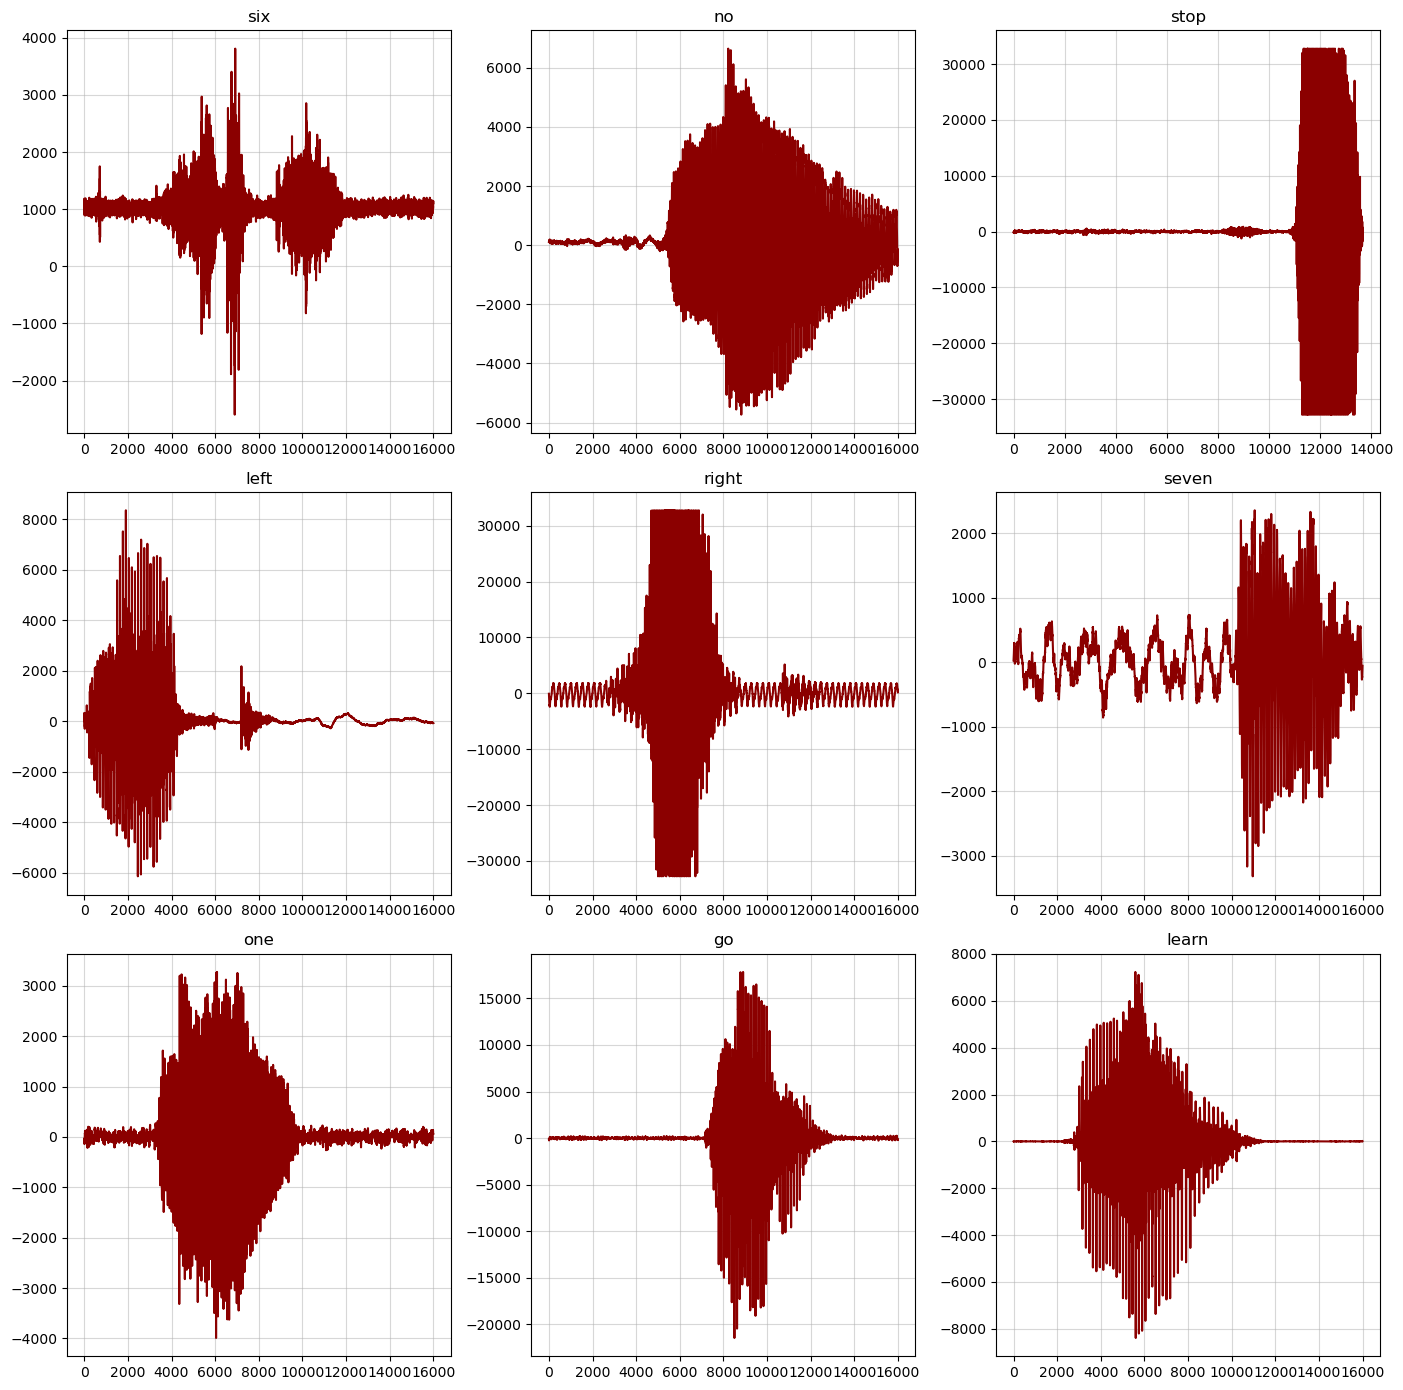

In [6]:
def plot_sample(path,commands):
    selected_commands = random.sample(commands, 9)
    fig, axs = plt.subplots(3, 3, figsize=(14, 14))
    
    for index, command in enumerate(selected_commands):
        dir_path = os.path.join(path, command)
        wav_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]


        selected_wav = random.choice(wav_files)
        selected_wav_path = os.path.join(dir_path, selected_wav)

        # Read and plot the wav file
        data = preprocessing.read_wavfile(selected_wav_path)

        # Plot the wav file
        ax = axs[index // 3, index % 3]
        ax.plot(data,color='darkred')
        ax.grid(alpha=0.5)
        ax.set_title(f"{command}", fontsize=12)

    plt.tight_layout()
    plt.show()
plot_sample(DATASET_PATH,commands)

## Data shape

According to [Warden18], the audio data should be available in the format of 16 kHz WAV files. In this context, we will verify whether there are any files in the dataset that deviate from this specified format.

In [7]:
def check_shape(directory_path):
    # Lists to store file paths of shorter and longer WAV files
    shorter_files = []
    longer_files = []
     # List all subdirectories
    subdirectories = [d for d in os.listdir(directory_path) 
                      if os.path.isdir(os.path.join(directory_path, d)) and d != '_background_noise_']
    for dir_name in subdirectories:
        dir_path = os.path.join(directory_path, dir_name)

        # List all wav files in the subdirectory
        wav_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]

        for wav_file in wav_files:
            file_path = os.path.join(dir_path, wav_file)
            _, data = preprocessing.wavfile.read(file_path)
            data = data.squeeze()

            if data.shape[0] < 16000:
                shorter_files.append(file_path)
            elif data.shape[0] > 16000:
                longer_files.append(file_path)

                
    return shorter_files, longer_files

In [8]:
shorter_files, longer_files = check_shape(DATASET_PATH)
# Print the number of shorter and longer WAV files
print(f"Number of shorter WAV files: {len(shorter_files)}")
print(f"Number of longer WAV files: {len(longer_files)}")

Number of shorter WAV files: 10435
Number of longer WAV files: 0


We have identified 10,435 WAV files in the dataset with a sample rate lower than 16 kHz. During preprocessing, we will pad these files with zeros until they reach a length corresponding to a 16 kHz sample rate. Since there are no files exceeding 16 kHz in the dataset, there is no need to trim any data.

## Train, Validation and Test data 

The train, validation, and test split of the data is determined by the files testing_list.txt and validation_list.txt. All files not included in either of these lists are assigned to the training set.

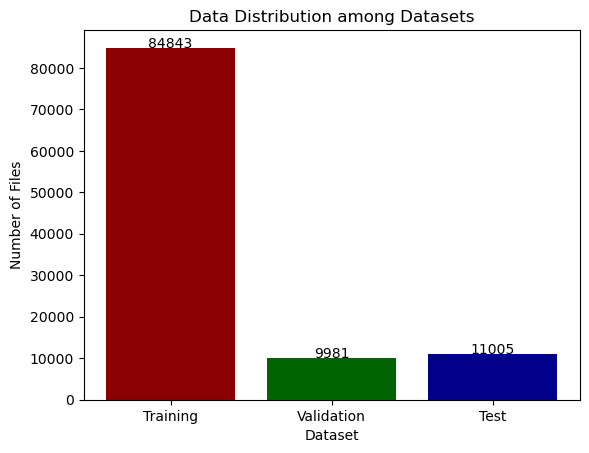

Total number of files: 105829


In [9]:
def read_file_list(filename):
    with open(filename, 'r') as file:
        return set(file.read().splitlines())

def count_datasets(data_path, test_file, val_file):
    test_list = read_file_list(os.path.join(data_path, test_file))
    val_list = read_file_list(os.path.join(data_path, val_file))

    test_count = len(test_list)
    val_count = len(val_list)

    train_count = 0
    for dirpath, _, filenames in os.walk(data_path):
        # Skip the _background_noise_ folder
        if '_background_noise_' in dirpath:
            continue

        for filename in filenames:
            if filename.endswith('.wav'):
                file_relative_path = os.path.join(os.path.basename(dirpath), filename)
                train_count += 1
    
    train_count = train_count - val_count - test_count

    return test_count, val_count, train_count

def plot_data_distribution(train_count, val_count, test_count):
    labels = ['Training', 'Validation', 'Test']
    counts = [train_count, val_count, test_count]

    plt.bar(labels, counts, color=['darkred', 'darkgreen', 'darkblue'])
    plt.xlabel('Dataset')
    plt.ylabel('Number of Files')
    plt.title('Data Distribution among Datasets')
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center')
    plt.show()
    
    
# Usage example
test_count, val_count, train_count = count_datasets(DATASET_PATH, 'testing_list.txt', 'validation_list.txt')
plot_data_distribution(train_count, val_count, test_count)
total_files = test_count + val_count + train_count

print(f"Total number of files: {total_files}")

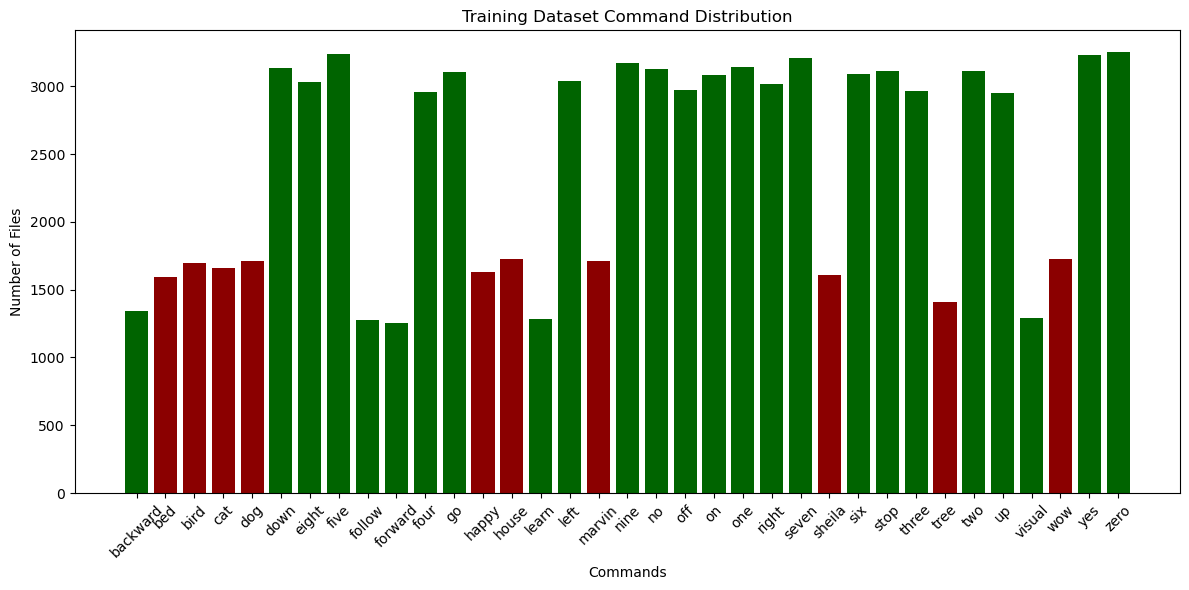

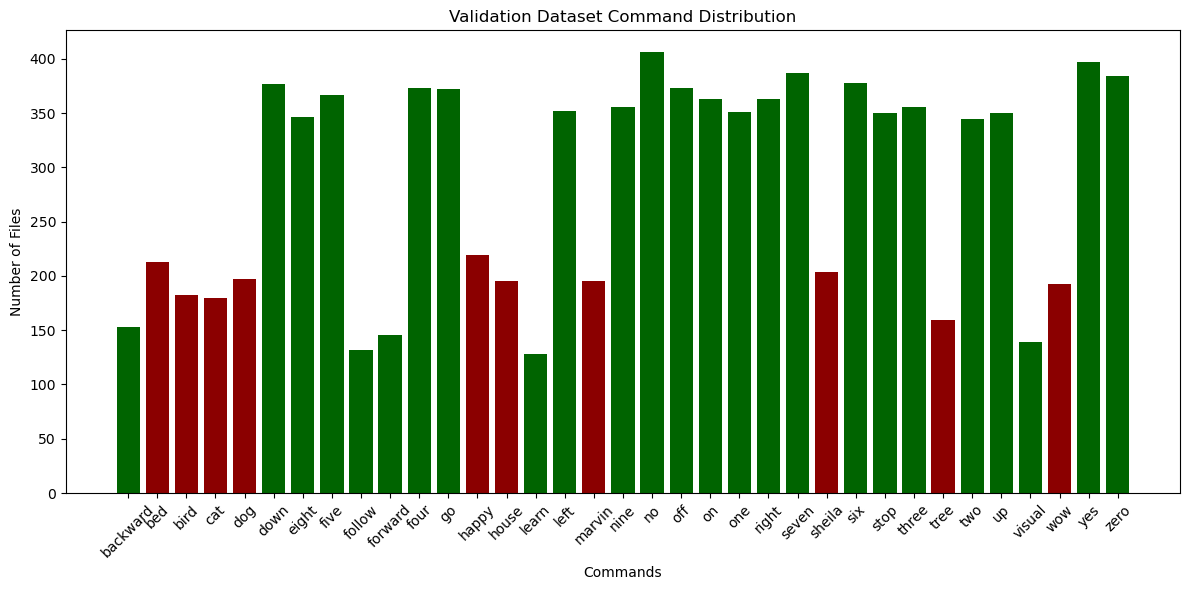

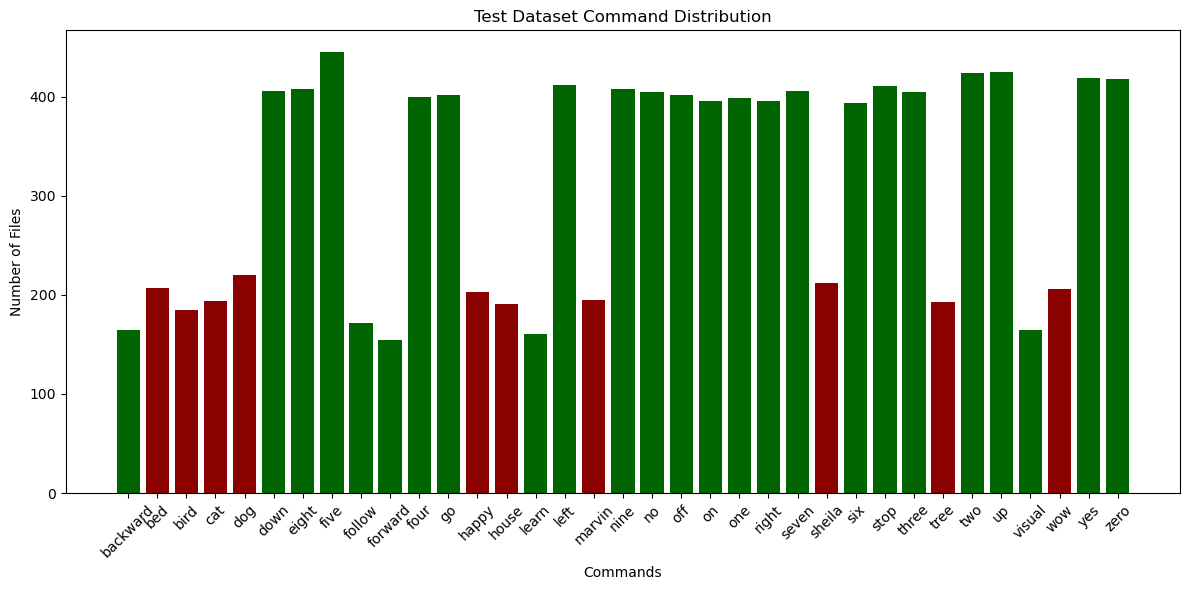

In [10]:
def count_datasets_by_command(data_path, test_file, val_file):
    test_list = read_file_list(os.path.join(data_path, test_file))
    val_list = read_file_list(os.path.join(data_path, val_file))

    test_counts = {}
    val_counts = {}
    train_counts = {}

    # List of directories to exclude
    exclude_dirs = {"_background_noise_"}

    for dirpath, _, filenames in os.walk(data_path):
        command = os.path.basename(dirpath)
        if command in exclude_dirs:
            continue

        for filename in filenames:
            if filename.endswith('.wav'):
                # Create the relative path from the dataset root
                file_absolute_path = os.path.join(dirpath, filename)
                file_relative_path = os.path.relpath(file_absolute_path, data_path)

                # Replace backslashes with forward slashes for compatibility
                file_relative_path = file_relative_path.replace('\\', '/')

                if file_relative_path in test_list:
                    test_counts[command] = test_counts.get(command, 0) + 1
                elif file_relative_path in val_list:
                    val_counts[command] = val_counts.get(command, 0) + 1
                else:
                    train_counts[command] = train_counts.get(command, 0) + 1

    return test_counts, val_counts, train_counts

def plot_command_distribution(command_counts, title, special_commands=None):
    commands = list(command_counts.keys())
    counts = list(command_counts.values())
    
    # Determine colors for each command
    colors = ['darkred' if command in special_commands else 'darkgreen' for command in commands]

    plt.figure(figsize=(12, 6))
    plt.bar(commands, counts, color=colors)
    plt.xlabel('Commands')
    plt.ylabel('Number of Files')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage example
test_counts, val_counts, train_counts = count_datasets_by_command(DATASET_PATH, 'testing_list.txt', 'validation_list.txt')
no_trigger_words = ["bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]


# Plotting distributions with specified colors
plot_command_distribution(train_counts, 'Training Dataset Command Distribution', no_trigger_words)
plot_command_distribution(val_counts, 'Validation Dataset Command Distribution', no_trigger_words)
plot_command_distribution(test_counts, 'Test Dataset Command Distribution', no_trigger_words)


## Background Noise

In addition to the subdirectories for the 35 commands, the dataset includes a subdirectory containing background noise. This noise should be integrated into the data to simulate situations closer to real-life environments.

In [11]:
#Adding background noise
# List all items in the directory
background_noise_dir = os.path.join(DATASET_PATH, "_background_noise_")
background_noise = os.listdir(background_noise_dir)

# Initialize counter for .wav files
wav_file_count = 0

# Print file names and shapes
for noise in background_noise:
    file_path = os.path.join(background_noise_dir, noise)
    if os.path.isfile(file_path) and file_path.endswith('.wav'):
        # Read the WAV file
        _, data = wavfile.read(file_path)
        # Print file name and shape
        print(f"{noise}: Shape - {data.shape}")

        # Increment the .wav file counter
        wav_file_count += 1

# Print total number of .wav files
print(f"Total number of background noises: {wav_file_count}")

doing_the_dishes.wav: Shape - (1522930,)
dude_miaowing.wav: Shape - (988891,)
exercise_bike.wav: Shape - (980062,)
pink_noise.wav: Shape - (960000,)
running_tap.wav: Shape - (978488,)
white_noise.wav: Shape - (960000,)
Total number of background noises: 6


C:\Users\maren\AppData\Local\Temp\ipykernel_35060\344622197.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


The dataset includes six different background noises, four of which are recordings of real-life sounds: `doing_the_dishes.wav`,`dude_miaowing.wav`,`exercise_bike.wav`,`running_tap.wav`
Additionally, there are two artificially generated noises: `white_noise.wav` and `pink_noise.wav`. The duration of these noise files exceeds 16 kHz. Therefore, during preprocessing, we will select a random 16 kHz-long sample from each noise file to add to the data. This approach ensures that the added background noise is consistent with the length of the audio commands in the dataset.

### Example of adding background noise to an audio sample from the data 

C:\Users\maren\PycharmProjects\HDA_KW\preprocessing.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


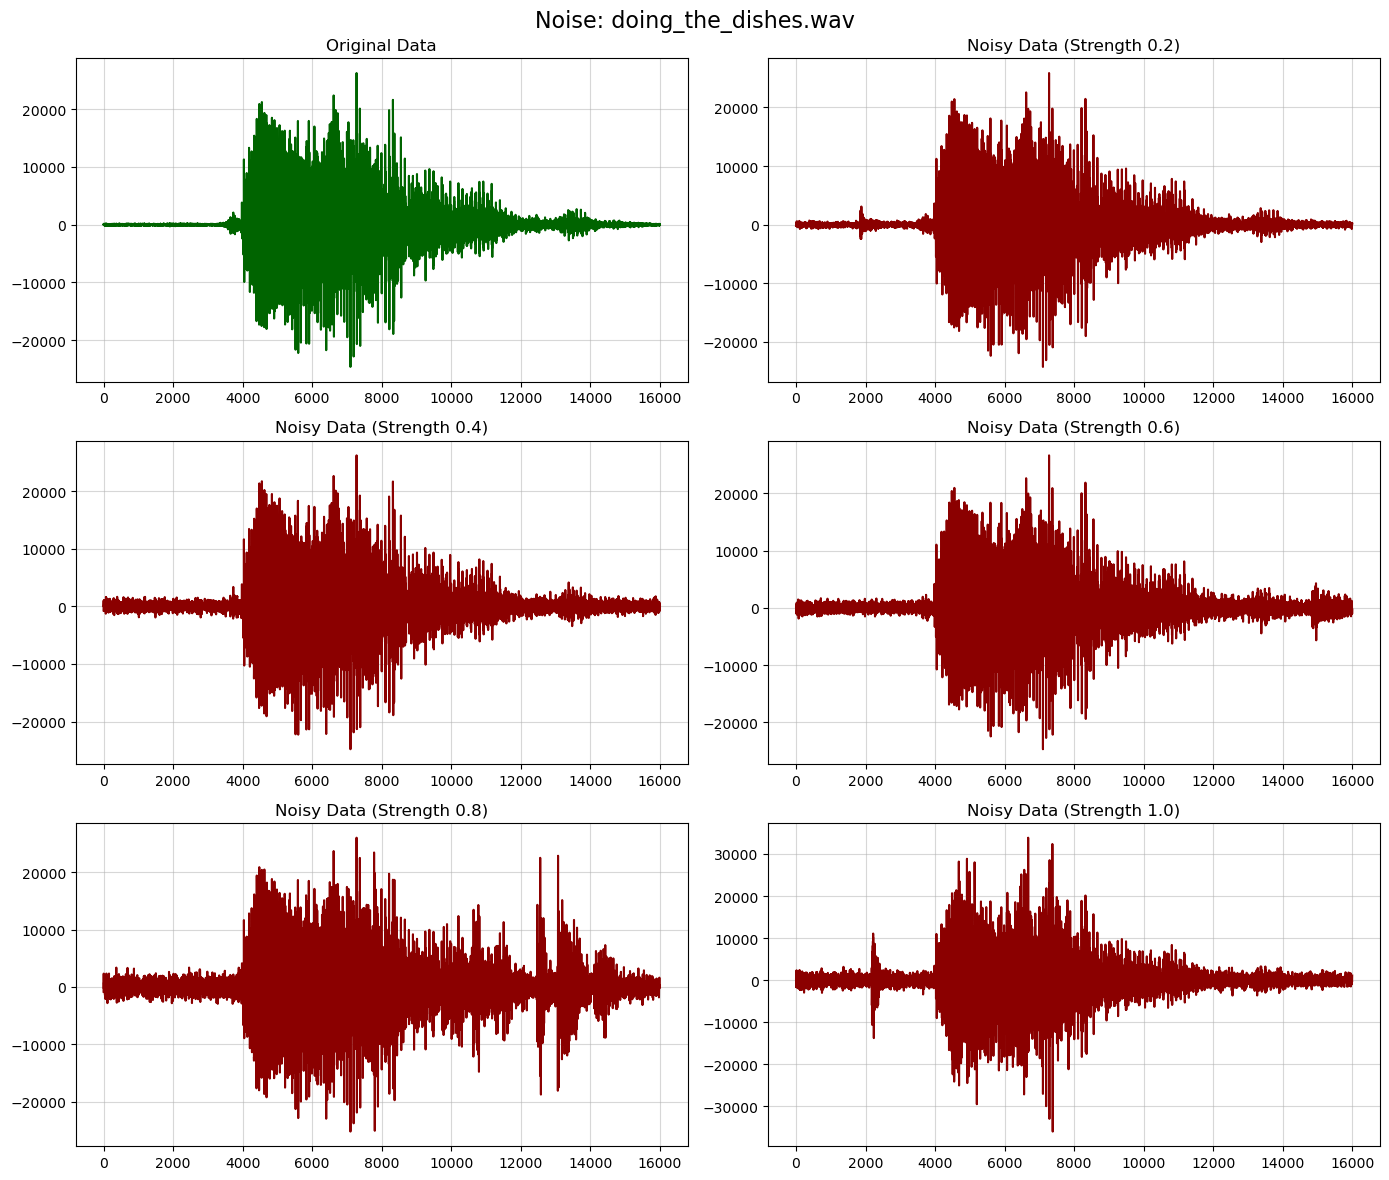

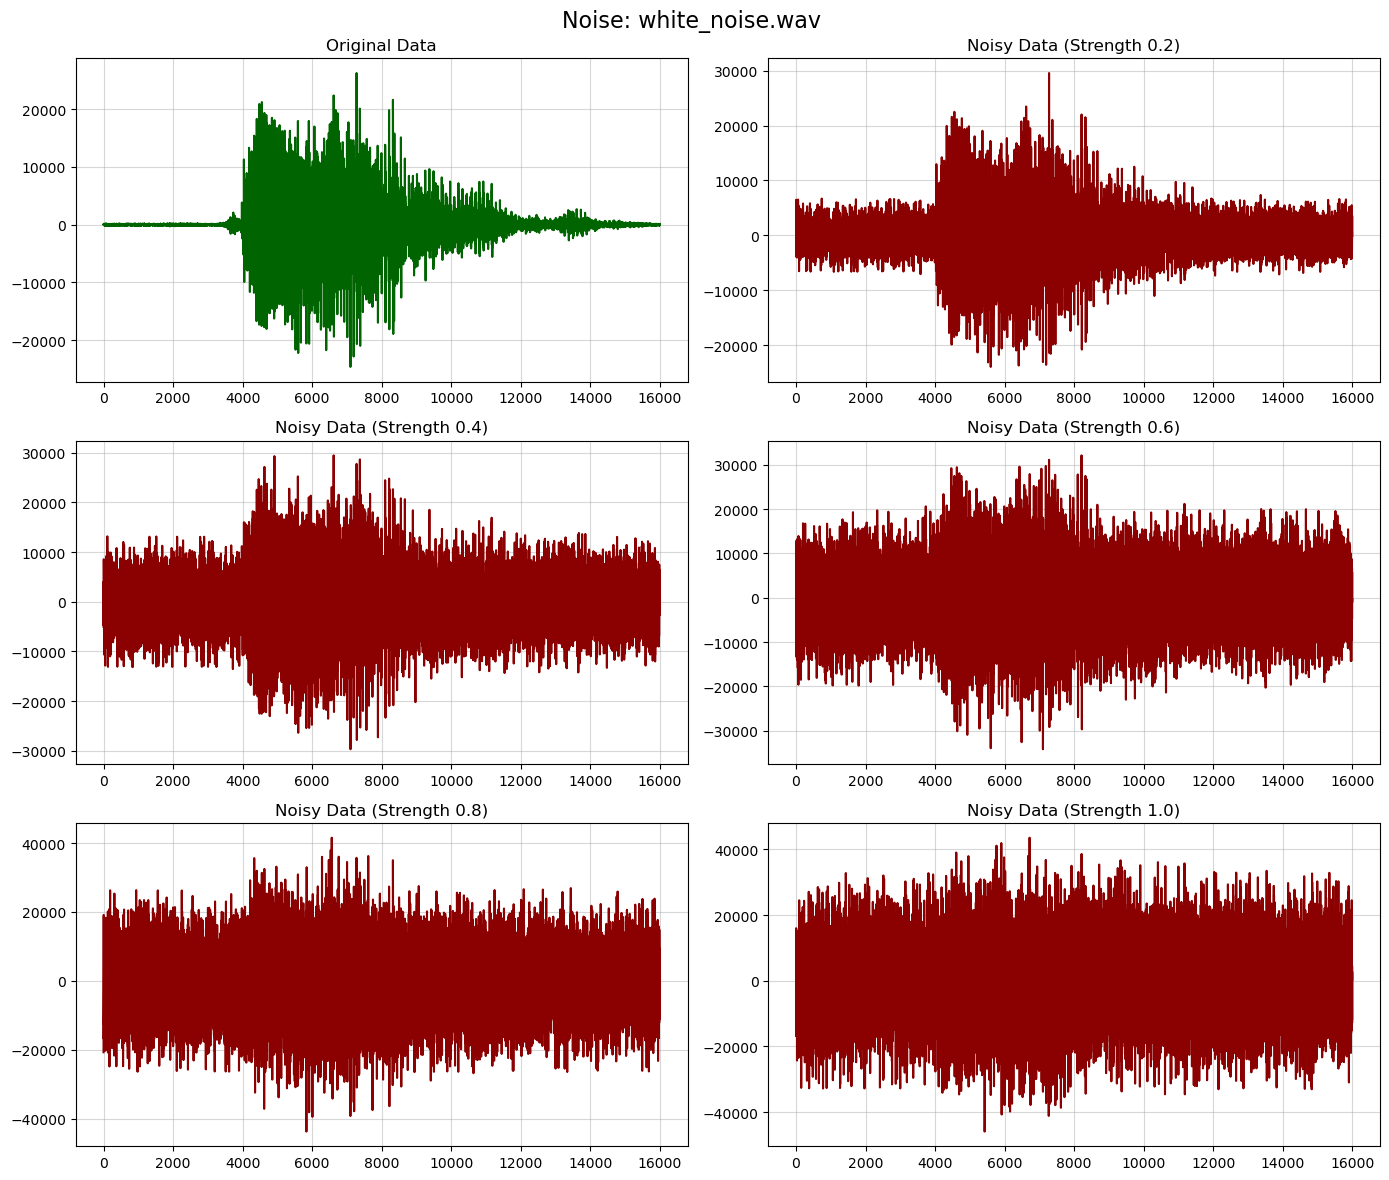

In [12]:
def plot_noisy_data(sample_data, noise_file, header,noise_strengths=[0.2, 0.4, 0.6, 0.8, 1.0]):
    # Create noisy data with different strengths
    noisy_data = [preprocessing.add_noise(sample_data, DATASET_PATH, strength, noise_file) for strength in noise_strengths]

    # Create subplots
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle(header, fontsize=16)
    
    # Plot original data in the top-left position
    axs[0, 0].plot(sample_data, color='darkgreen', label='Original Data')
    axs[0, 0].set_title('Original Data')
    axs[0, 0].grid(alpha=0.5)

    # Plot noisy data in the remaining positions
    for i, data in enumerate(noisy_data):
        # Calculate row and column for current plot
        row = (i + 1) // 2
        col = (i + 1) % 2
        axs[row, col].plot(data, color='darkred', label=f'Noisy Data (Strength {noise_strengths[i]})')
        axs[row, col].set_title(f'Noisy Data (Strength {noise_strengths[i]})')
        axs[row, col].grid(alpha=0.5)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Usage example
sample_data = preprocessing.read_wavfile(os.path.join(DATASET_PATH, "five/00b01445_nohash_0.wav"))

# Plot with "doing_the_dishes.wav" noise
plot_noisy_data(sample_data, "doing_the_dishes.wav",header="Noise: doing_the_dishes.wav")

# Plot with "white_noise.wav" noise
plot_noisy_data(sample_data,"white_noise.wav",header = "Noise: white_noise.wav ")

When adding noise to the audio data, we found that a noise with strength 0.6 makes it challenging to discern the spoken word in the waveform, particularly with the white noise process. Consequently, we will limit the intensity of the noise added to the training data to a range between 0.2 and 0.5. This range ensures that the noise enhances the dataset's realism without overly obscuring the speech commands.

# Preprocessing

## Example preprocessing 
The following outlines our preprocessing pipeline, demonstrated with the file da7689f1_nohash_0.wav, which contains a recording of a person saying the word "eight":

In [13]:
#filename_mess = 'C:\\Users\\maren\\OneDrive\\HDA_Project\\project_data\\backward\\1474273a_nohash_0.wav'
filename = 'C:\\Users\\maren\\OneDrive\\HDA_Project\\project_data\\eight\\da7689f1_nohash_0.wav'

Read the file and listen and plot the audio data

In [14]:
sample_file = preprocessing.read_wavfile(filename)

In [15]:
Audio(sample_file, rate=16000)

<Figure size 1200x600 with 0 Axes>

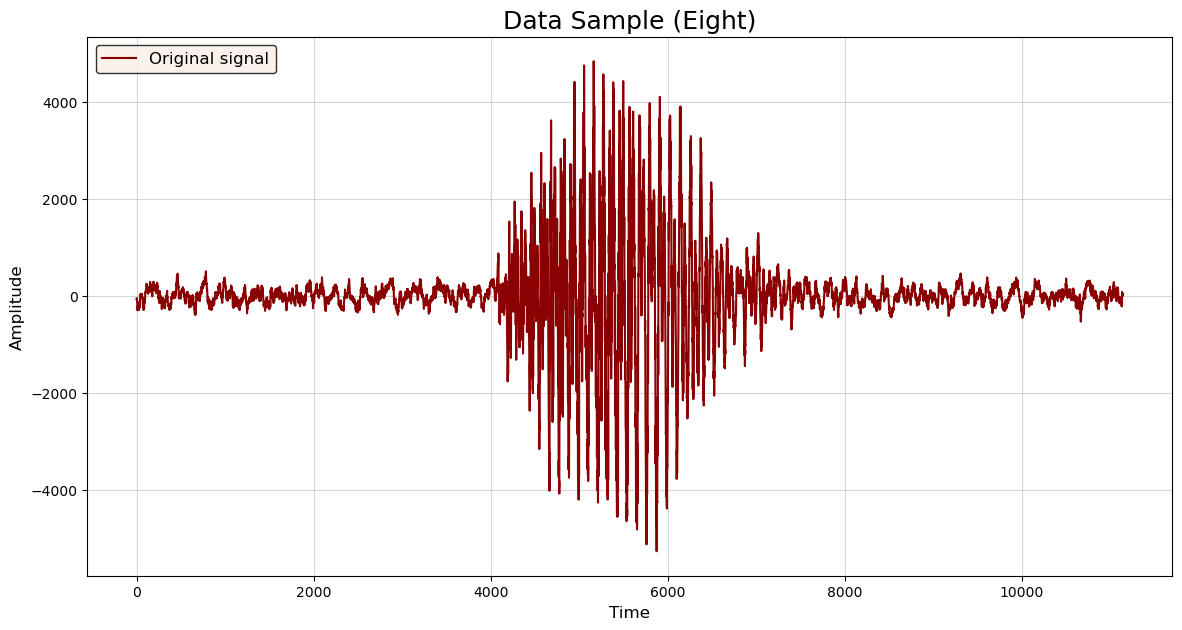

In [16]:
# Plot the original sampled data
plt.figure(figsize=(12, 6))

# Modified design to match the second plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.arange(0, sample_file.shape[0]), sample_file, color='darkred', label='Original signal', zorder=2)
ax.grid(alpha=0.5)
ax.set_title("Data Sample (Eight)", fontsize=18)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc='upper left')
plt.show()

In [17]:
sample_file.shape

(11146,)

The waveform indicates that padding is required for this file.

## Padding
pad the data with zeroes from both sides left and right equally

In [18]:
data_pad = preprocessing.perform_padding(sample_file, data_length=16000)

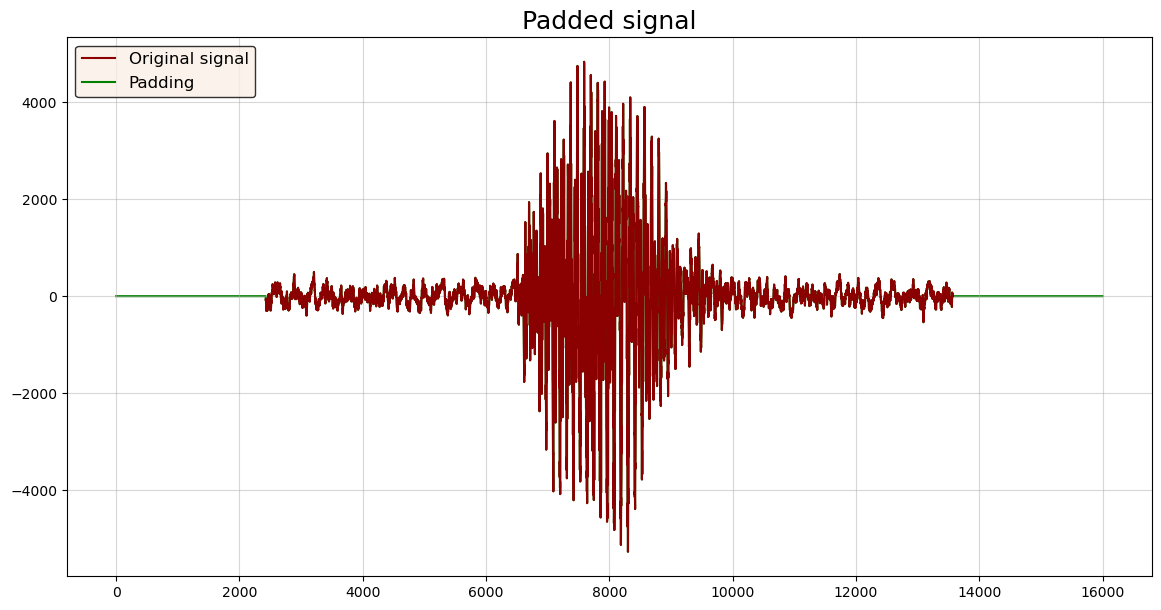

In [19]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.arange((16000-sample_file.shape[0])//2, (16000-sample_file.shape[0])//2+sample_file.shape[0]), sample_file, color='darkred', label='Original signal', zorder=2)
ax.plot(data_pad, color='green', label='Padding', zorder=1)
ax.grid(alpha=0.5)
ax.set_title("Padded signal", fontsize=18)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='upper left')
plt.show()

## Add noise 
To enhance the realism of the dataset and better simulate real-life scenarios, we will add background noise to the audio data. The type of background noise used is selected randomly from the six available options. Additionally, the intensity of the noise added will vary randomly between 0.2 and 0.5, in increments of 0.05. This approach ensures a diverse and realistic augmentation of the dataset.

In [20]:
data_noise = preprocessing.add_noise(data_pad, DATASET_PATH)

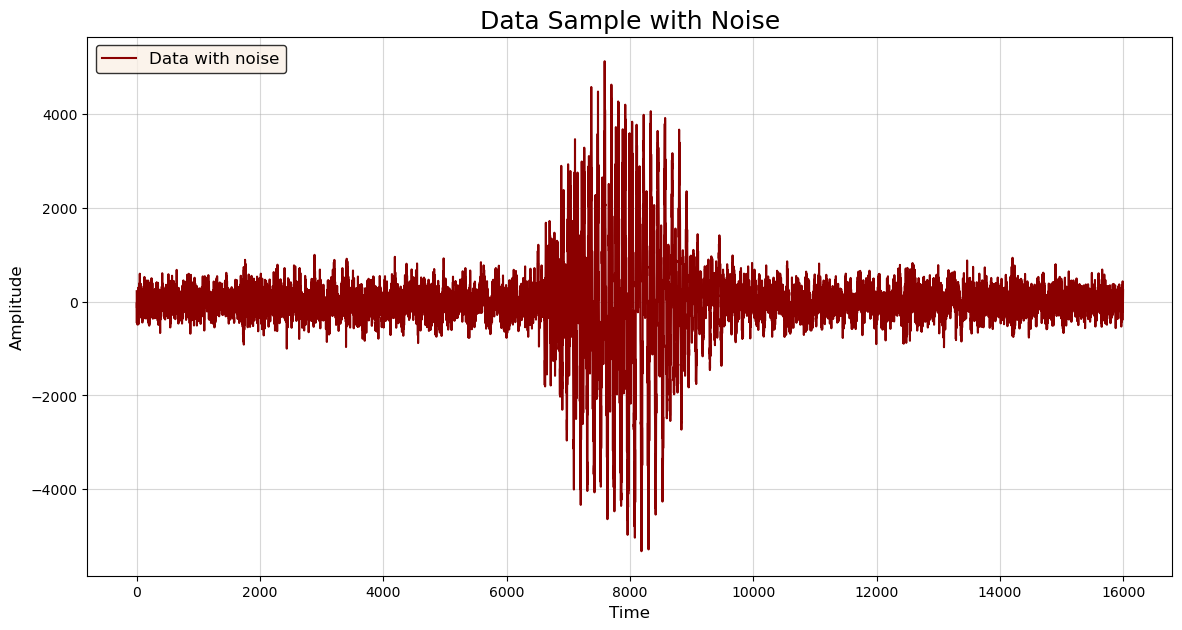

In [21]:
# Modified design to match the enhanced plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.arange(0, data_noise.shape[0]), data_noise, color='darkred', label='Data with noise', zorder=2)
ax.grid(alpha=0.5)
ax.set_title("Data Sample with Noise", fontsize=18)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc='upper left')
plt.show()

Listen to the noise data; to the human ear, the word "eight" remains recognizable.

In [22]:
Audio(data_noise, rate=16000)

## Resampling

Sample the data down to 8000 Hz. This sampling rate is frequently used in telecommunications. By resampling the data to a sampling rate of 8000 Hz, we effectively reduce the dimensionality of our data by 50%.

In [23]:
data_resampled = preprocessing.resample_data(data_noise)

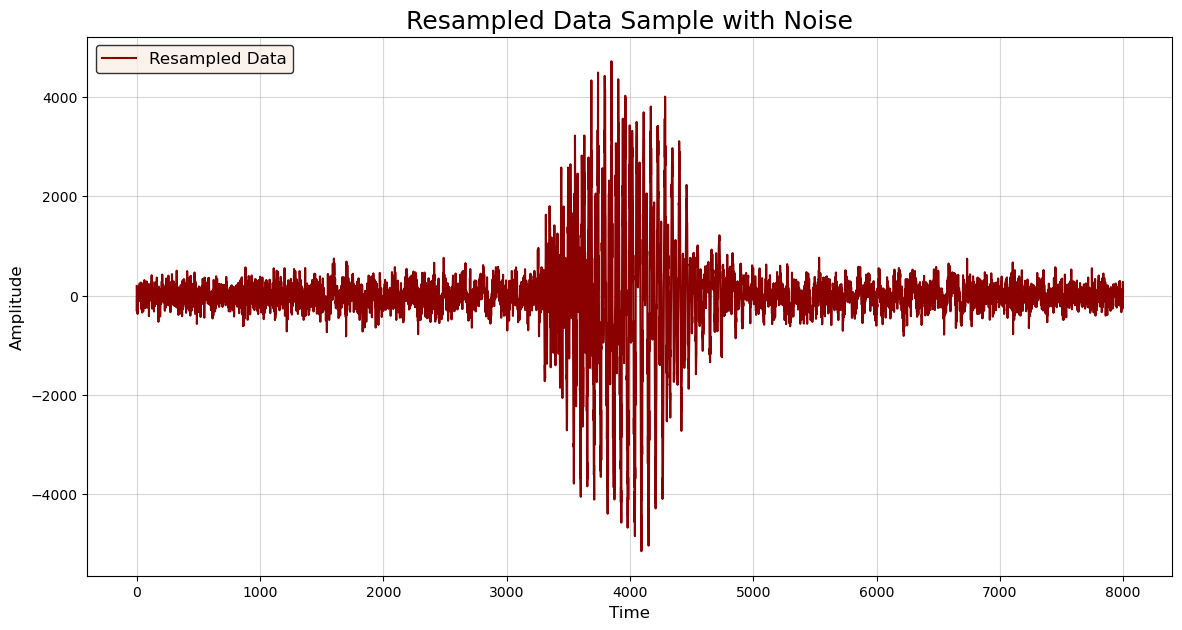

In [24]:
# Modified design to match the enhanced plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(np.arange(0, data_resampled.shape[0]), data_resampled, color='darkred', label='Resampled Data', zorder=2)
ax.grid(alpha=0.5)
ax.set_title("Resampled Data Sample with Noise", fontsize=18)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc='upper left')
plt.show()

## Spectrogram

In the dataset, the audio waveforms are initially in the time domain. To analyze these signals, we will apply the Short-Time Fourier Transform (STFT) to transform them into frequency-domain representations. This process generates spectrograms that depict how frequencies vary over time. These spectrograms can be visualized as 2D images. Our neural network will be trained using these spectrogram images, providing a basis for understanding and classifying the audio data.

In [25]:
spectrogram = preprocessing.get_spectrogram(data_resampled, samplerate = 8000)

Feature vector shape: (257, 98)


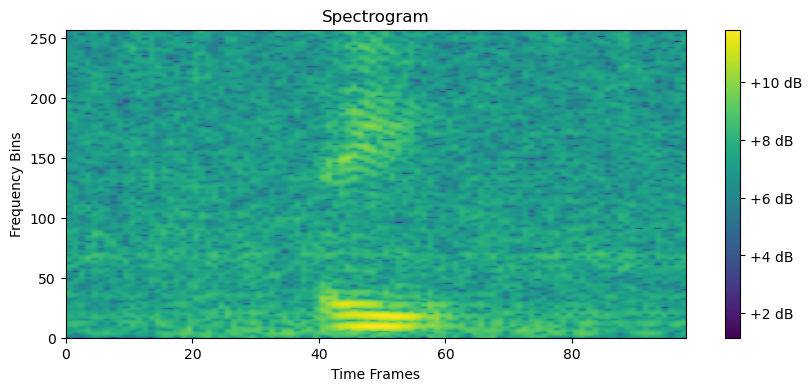

In [26]:
print("Feature vector shape:", spectrogram.shape)

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower',
           extent=[0, spectrogram.shape[1], 0, spectrogram.shape[0]])
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.show()

## Log Mel-filterbank energy features


In our dataset, we transform audio waveforms from the time domain to a more perceptually relevant representation using Log Mel-filterbank energy features. This process involves:

**Applying the STFT**: We use the Short-Time Fourier Transform with 25 millisecond windows and a 10 millisecond step between windows to convert audio signals to the frequency domain.

**Mel-Scale Filterbank**: The frequency-domain signal is processed through a filterbank of 40 Mel-scale filters, covering frequencies from 300 Hz to half the sampling rate.

**Energy Computation and Logarithmic Transformation**: We compute the energy in each Mel filter and apply a logarithmic transformation to align with human auditory perception.

**Feature Preparation**: The resulting log Mel-filterbank energy features form a matrix, which is transposed and converted to 32-bit floating-point format for neural network input.

This method results in a 2D representation that effectively captures sound characteristics, providing a solid foundation for training our neural network in audio classification tasks.

In [27]:
logfbank = preprocessing.get_logfbank(data_resampled, samplerate = 8000)

Feature vector shape: (40, 99)


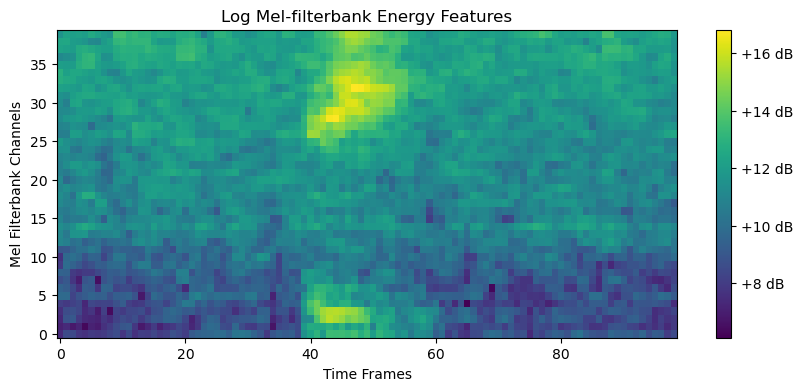

In [28]:
print("Feature vector shape:", logfbank.shape)

plt.figure(figsize=(10, 4))
plt.imshow(logfbank, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel-filterbank Energy Features')
plt.xlabel('Time Frames')
plt.ylabel('Mel Filterbank Channels')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCC)


MFCC, or Mel-Frequency Cepstral Coefficients, is a method used to extract salient features from audio signals. This technique involves dividing the frequency spectrum of the audio signal into bands using the Mel scale and then computing coefficients from these individual bands, effectively distinguishing between different frequencies. The extraction process employs the Discrete Cosine Transform (DCT). The Mel scale is based on human auditory perception, reflecting how our brains process and distinguish various audio frequencies.

In our standard approach, we compute MFCC features by segmenting the audio signal into frames of 25 milliseconds with a frame shift of 10 milliseconds, and we utilize 40 Mel filterbanks for this analysis.

In [29]:
mfcc = preprocessing.get_mfcc(data_resampled, samplerate = 8000)

Feature vector shape: (39, 99)


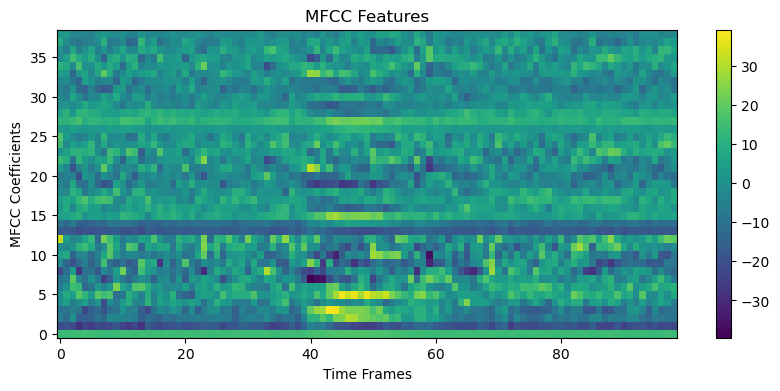

In [30]:
print("Feature vector shape:", mfcc.shape)

plt.figure(figsize=(10, 4))
plt.imshow(mfcc, aspect='auto', origin='lower')
plt.colorbar()
plt.title('MFCC Features')
plt.xlabel('Time Frames')
plt.ylabel('MFCC Coefficients')
plt.show()

## Data splitting

In the `train_test_val_split.py` script, the data is divided into train, validation, and test sets based on the contents of `validation_list.txt` and `testing_list.txt`. Files not listed in either the validation or test lists are automatically allocated to the training dataset. The files are organized into corresponding directories (train, test, validation), each of those directories maintains the same file structure as the original data, with each command represented by a separate subdirectory.
 

In [31]:
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

In [32]:
#split the data
#test_path = 'C:\\Users\\maren\\OneDrive\\HDA_Project\\test\\project_data_split'
train_test_val_split.split_data(DATASET_PATH,DATASET_SPLIT_PATH)

In [33]:
#check if the count matches the expected numbers from the exploratory analysis
#test_path = 'C:\\Users\\maren\\OneDrive\\HDA_Project\\test\\project_data_split\\train'
train_files = count_files_in_directory(os.path.join(DATASET_SPLIT_PATH,"train"))
validation_files = count_files_in_directory(os.path.join(DATASET_SPLIT_PATH,"validation"))
test_files = count_files_in_directory(os.path.join(DATASET_SPLIT_PATH,"test"))

print(f"The number of files in the train set is {train_files}")
print(f"The number of files in the validation set is {validation_files}")
print(f"The number of files in the test set is {test_files}")

The number of files in the train set is 84843
The number of files in the validation set is 9981
The number of files in the test set is 11005


## Preprocessing the whole dataset

Apply the previously outlined preprocessing pipeline on the entire dataset. Individual steps such as resampling, log Mel filterbanks, and MFCC can be toggled on or off (by setting the relevant parameters to true or false). This approach allows for an assessment of model performance with and without these preprocessing methods, and thus helps in evaluating the effectiveness of these techniques.

In [34]:
train_data = preprocessing.preprocess(DATASET_SPLIT_PATH,"train",resample=True, logfbank = False, mfcc = True)
val_data = preprocessing.preprocess(DATASET_SPLIT_PATH,"validation",resample=True, logfbank = False, mfcc = True)
test_data = preprocessing.preprocess(DATASET_SPLIT_PATH,"test",resample=True, logfbank = False, mfcc = True)

Done preprocessing
Done preprocessing
Done preprocessing


In [35]:
train_data.head()

,Command,Filename,Spectrogram
0,backward,0165e0e8_nohash_0.wav,"[[21.41445, 21.352327, 21.422077, 21.349047, 2..."
1,backward,017c4098_nohash_0.wav,"[[21.018448, 21.141926, 21.056828, 21.244898, ..."
2,backward,017c4098_nohash_1.wav,"[[17.47411, 17.189274, 17.481642, 17.505503, 1..."
3,backward,017c4098_nohash_2.wav,"[[20.201885, 19.922297, 20.186068, 20.33969, 2..."
4,backward,017c4098_nohash_3.wav,"[[20.218815, 20.374565, 20.228874, 20.062347, ..."


# References

[Warden18] Pete Warden, Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition, arXiv:1804.03209, April 2018.